<a href="https://colab.research.google.com/github/MaximR002/a-b_tests/blob/main/A%7CB_test_with_share_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Share metric - Доли. Бинарные сигналы, например, конверсия в покупку или retention rate.

##Разберем дизайн A|B теста на примере конверсии в покупку.(Предположим, что мы изменили кнопку купить)
##Импортируем необходимые библиотеки, для работы с данными и статистикой

In [ ]:
import numpy as np
import pandas as pd
import scipy as s
import matplotlib.pyplot as plt


##Cформулируем гипотезы, а также обозначим ошибку первого рода, мощность и минимальный эффект, который хотим задетектировать.
###H0 - конверсия в контрольной группе = конверсии в тестовой группе
###H1 - конверсия в тестовой группе < конверсия в контрольной группе
#### Ошибку первого рода установим на уровне - 0.05 (alpha)
#### Ошибку второго рода установим на уровне - 0.1 (beta)
#### Мощность соответственно равна 1 - beta = 0.9
#### Эффект, который мы хотим задетектировать, на основе прошлых данных = 0.1(mde)

##Создадим функцию, которая поможет нам оценивать размер выборки при необходимом эффекте, уровне ошибки первого и мощности.

In [ ]:
def calculate_sample_size(effect_size, alpha, power):
    """
    Функция для расчета размера выборки для A/B-теста.

    :param effect_size: размер эффекта (например, стандартизированное различие между группами)
    :param alpha: уровень статистической значимости
    :param power: статистическая мощность
    :return: размер выборки для каждой группы
    """
    # Используем z-значения для определения критических значений
    z_alpha = abs(s.stats.norm.ppf(alpha / 2)) # z-значение для двусторонней альтернативы
    z_power = abs(s.stats.norm.ppf(power))

    # Расчет размера выборки
    sample_size = ((z_alpha + z_power) ** 2) * 2 * (1 / effect_size ** 2)

    return np.ceil(sample_size)

In [ ]:
n_samples = calculate_sample_size(0.1, 0.05, 0.9)
n_samples

2102.0

## Исходя из нашей функции видим, что для нахождения статистически значимого различия с effect_size = 0.1 между 2 группами при вероятности ошибки первого рода в 5% и вероятности ошибки второго рода в 10%, нам необходимо 2 выборки размером 2102 респондента.

##Создадим генератор выборок

In [ ]:
def generate_samples(n_samples, conversion_rate):
    """
    Генерирует выборку для конверсии в покупку.

    Args:
    - n_samples: Размер выборки.
    - conversion_rate: Конверсионная ставка в виде доли (например, 0.05 для 5%).

    Returns:
    - samples: Массив выборки конверсии в покупку.
    """
    samples = np.random.binomial(n=1, p=conversion_rate, size=n_samples)
    return samples

##Предположим, что эти выборки мы уже обрабатываем после хода самого эксперимента

In [ ]:
group_a = generate_samples(2102, 0.5)
group_b = generate_samples(2102, 0.6)

##Посмотрим на распеределение в тестовой и контрольной группе

Text(0.5, 1.0, 'Контрольная группа')

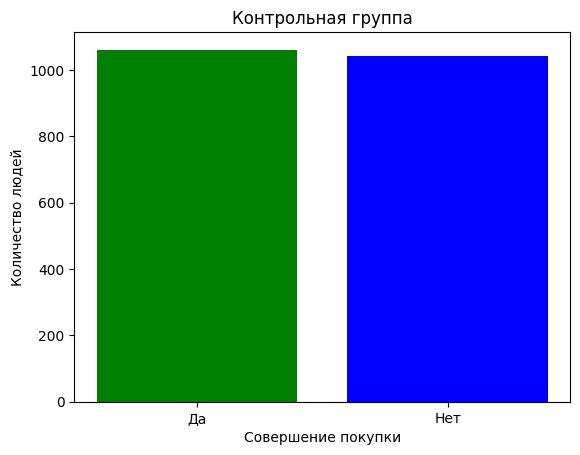

In [ ]:
labels = ['Да', 'Нет']
count_zeroes_a = len(list(filter(lambda x: x == 0, group_a)))
count_ones_a = len(list(filter(lambda x: x == 1, group_a)))

plt.bar(labels, [count_zeroes_a, count_ones_a], color=['green', 'blue'])
plt.ylabel('Количество людей')
plt.xlabel('Совершение покупки')
plt.title('Контрольная группа')

Text(0.5, 1.0, 'Тестовая группа')

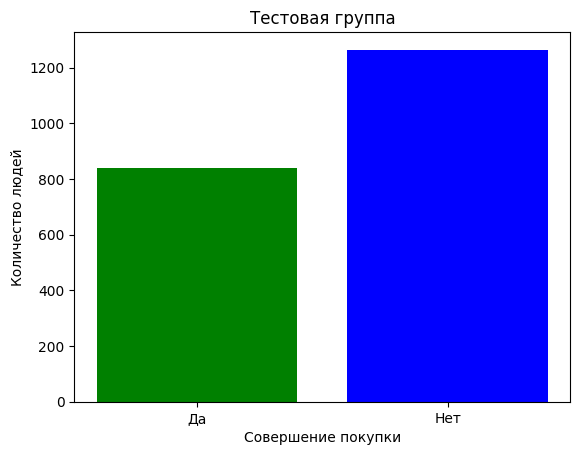

In [ ]:
count_zeroes_b = len(list(filter(lambda x: x == 0, group_b)))
count_ones_b = len(list(filter(lambda x: x == 1, group_b)))

plt.bar(labels, [count_zeroes_b, count_ones_b], color=['green', 'blue'])
plt.ylabel('Количество людей')
plt.xlabel('Совершение покупки')
plt.title('Тестовая группа')

## Заметим, что есть различия между тестовой и контрольной группой.
## Но значимы ли они?

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
stat, pval = proportions_ztest([count_ones_a, count_ones_b], [count_zeroes_a + count_ones_a, count_zeroes_b + count_ones_b])
pval

4.8139072239652714e-12

## Мы видим, что pval намного меньше уровня вероятности 0.05, поэтому мы можем не принимать нулевую гипотезу о равенстве конверсий в тестовой и контрольной группе.

##Построим 95-% доверительный интервал на основе тестовой группы, чтобы понять как повлияет изменение кнопки на всю популяцию.

In [ ]:
def bootstrap_sample(group_b):
    n = len(group_b)
    indices = np.random.choice(n, n, replace=True)
    return group_b[indices]

In [ ]:
def bootstrap_proportion(group_b, num_samples=10000, confidence_level=0.95):
    proportions = []
    for _ in range(num_samples):
        sample = bootstrap_sample(group_b)
        proportion = np.mean(sample)
        proportions.append(proportion)
    # Вычисление доверительного интервала
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(proportions, lower_percentile)
    upper_bound = np.percentile(proportions, upper_percentile)
    return np.mean(proportions), (lower_bound, upper_bound)

In [ ]:
mean_proportion, confidence_interval = bootstrap_proportion(group_b)

print("Оценка доли:", mean_proportion)
print("Доверительный интервал:", confidence_interval)

Оценка доли: 0.6015547573739296
Доверительный интервал: (0.5803996194100857, 0.6217887725975262)


### Мы видим, что при "раскатке" изменения кнопки на всю популяцию с вероятностью 95% изменение в целевой метрике(конверсии) будет лежать в интервале: (0.5803996194100857, 0.6217887725975262)